# [Bacterial chemotaxis](@id Chemotaxis)

We use the model of bacterial cells by [Volfson et al. (2008)](https://www.pnas.org/doi/abs/10.1073/pnas.0706805105) and modify it to add active movement to the bacteries.

Over the physical model we add some active forces and a tumbling displacement model. The original physical model can be found in `Models/rods.jl`. We can copy its code and modify it in the following.

 - Add to the moving force an additional propulsion term.
 - Add to the agents a tumble and run protocol.
 - Add a medium which the model will detect.
 - Keep cells inside some boundaries.

## Load packages

In [1]:
import Pkg
Pkg.activate("../")
Pkg.instantiate()


  Activating project at `c:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM`
Precompiling project...
        Info Given CellBasedModels was explicitly requested, output will be shown live 
┌ Warning: CUDA runtime library nvrtc64_112_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\u256063\.julia\packages\CUDA\jdJ7Z\src\initialization.jl:187
  ✓ CellBasedModels
  1 dependency successfully precompiled in 80 seconds. 439 already precompiled.
  1 dependency had output during precompilation:
┌ CellBasedModels
│  [Output was shown above]
└  


In [2]:
using CellBasedModels 
using GLMakie
Makie.inline!(true)
# using GeometryBasics
using Distributions
using CUDA

[ Info: Precompiling CellBasedModels [388cb286-f2b1-4654-a3bb-2e137a39c658]
┌ Warning: CUDA runtime library nvrtc64_112_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\u256063\.julia\packages\CUDA\jdJ7Z\src\initialization.jl:187
┌ Warning: CUDA runtime library nvrtc64_112_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\u256063\.julia\packages\CUDA\jdJ7Z\src\initialization.jl:187


## Modify the model

The model is a copy of the model as provided in `Models/rods.jl`. We mark the added lines to the code to adapt it to a chemotaxis model.

In [3]:
rods2DChemotaxis = ABM(2,
    agent = Dict(
            :vx=>Float64,
            :vy=>Float64,
            :theta=>Float64,
            :ω=>Float64,
            :d=>Float64,
            :l=>Float64,
            :m=>Float64,
            :fx=>Float64,
            :fy=>Float64,
            :W=>Float64,
            :pressure=>Float64,
            :tTumble=>Float64, #We add to the agent a time to tumble or to run
            :active=>Bool,     #Add a switch to change between tumbling and running
        ),

    model = Dict(
            :kn=>Float64,
            :γn=>Float64,
            :γt=>Float64,
            :μcc=>Float64,
            :μcw=>Float64,
            :β=>Float64,
            :βω=>Float64,
            :ωTumble=>Float64, #Add a torque of tumbling
            :τTumble=>Float64, #Add a frequency of tumbling
            :fChem=>Float64,   #Add a force of propulsion
            :DMedium=>Float64, #Add a diffusion constant of the medium
            :ωMedium=>Float64  #Add a frequency of the oscillating medium
        ),

    medium = Dict(
        :mm => Float64        #Add a medium parameter
    ),

    agentODE = quote

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin

            Fijx, Fijy, Wij = CBMModels.rodForces(
                                    x,y,d,l,theta,vx,vy,m,
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],vx[i2],vy[i2],m[i2],
                                    kn,γn,γt,μcc,μcw
                                )

            #Append the interaction forces
            fx += Fijx
            fy += Fijy
            #Append radial forces
            W += Wij
            #Keep track of preassure in the media
            pressure += sqrt(Fijx^2+Fijy^2)
            
        end

        #Equations
        dt(x) =  vx 
        dt(y) =  vy 
        dt(vx) =  -β*vx+fx/m + active * fChem * cos(theta) #Add the propulsion force
        dt(vy) =  -β*vy+fy/m + active * fChem * sin(theta) #Add the propulsion force
        dt(theta) =  ω
        dt(ω) =  W/(m*(d+l)^2/12+m*d^2)-βω*ω 
        
    end,

    agentRule = quote
        #Code rule switch between tumbling and running
        if tTumble < t && active #Activate tumbling if the particle was active (running) and the tumbling time ended
            vx = 0
            vy = 0
            active = false
            ω += ωTumble
            tTumble += 1.
        elseif tTumble < t && !active # Activate tumbling if the particle was tumbling (active off) and the running time ended (we resuse the tTumble time)
            ω = 0
            active = true
            tTumble += CBMDistributions.exponential((2-mm)*τTumble)
        end

        # Very rudementary rule to to fix the bacteries to move inside the boundaries using onluy the center of the rod
        if x < simBox[1,1]
            x = simBox[1,1]
        elseif x > simBox[1,2]
            x = simBox[1,2]
        end
        if y < simBox[2,1]
            y = simBox[2,1]
        elseif y > simBox[2,2]
            y = simBox[2,2]
        end

    end,

    #Medium dynamics with dirichlet conditions and a wall that is as oscillating source of material
    mediumODE=quote 
        if @mediumInside()
            dt(mm) = DMedium*@∂2(1,mm)# we only diffuse in x as the symmetry is in x
        elseif @mediumBorder(1,-1)
            mm = 0
        elseif @mediumBorder(1,1)
            mm = sin(ωMedium*t)+1 #Oscillatory behaviour
        elseif @mediumBorder(2,-1)
            mm = 0
        elseif @mediumBorder(2,-1)
            mm = 0
        end
    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=GPU()
);

## Initialising the community

In [4]:
com = Community(
    rods2DChemotaxis,
    N=75,
    dt=0.1,
    simBox=[-20 20;-20 20.],
    NMedium=[100,100],
)

m = 1/100
g = 1/10000
d = 1
com.kn = 2E6      * (m*g/d)
com.γn = 2.2E2    * sqrt(g/d)
com.γt = 2.2E2    * sqrt(g/d)
com.μcc = 0.1
com.μcw = 0.8
com.β = .8
com.βω = .8
com.fChem = 1
com.τTumble = 2
# com.τTumbleMin = 1
com.ωTumble = 1
com.ωMedium = .01
com.DMedium = 3

com.m = 1.        
com.d = 1.        
com.l = 3;
com.x = rand(Uniform(com.simBox[1,:]...),com.N)
com.y = rand(Uniform(com.simBox[2,:]...),com.N)
com.theta = rand(Uniform(0,2π),com.N);

## Evolving the community

As the evolution function may take some time, we add a progress message to the evolution to provide information of progress.

In [5]:
evolve!(com,steps=100,saveEach=10,progressMessage=(com)->println("Step: ",round(Int,com.t)*10))

Step: 10
Step: 20
Step: 30
Step: 40
Step: 50
Step: 60
Step: 70
Step: 80
Step: 90
Step: 100


## Plot of the results

 - We plot samples of the medium and bacteries.
 - The mean position of the bacteries over time.

In [6]:
fig = Figure(resolution=(1800,400))

for (j,i) in enumerate(1:round(Int,length(com)/4):length(com))
    begin
        d = getParameter(com,[:x,:y,:d,:l,:theta,:pressure,:mm])

        ax = Axis(fig[1,2*j-1])

        m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.mm)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.mm)[1]),
                d[:mm][i],
                colorrange=(0,2.)
            )

        xlims!(com.simBox[1,:]...)
        ylims!(com.simBox[2,:]...)

        x = Observable(d[:x][i])
        y = Observable(d[:y][i])
        xs1 = Observable(d[:x][i]+d[:l][i]./2 .*cos.(d[:theta][i]))
        ys1 = Observable(d[:y][i]+d[:l][i]./2 .*sin.(d[:theta][i]))
        xs2 = Observable(d[:x][i]-d[:l][i]./2 .*cos.(d[:theta][i]))
        ys2 = Observable(d[:y][i]-d[:l][i]./2 .*sin.(d[:theta][i]))
        ms = Observable([Point3f0(i/2,i/2,0) for i in d[:d][i]])
        mc = Observable([Point3f0(ll,dd/2,dd/2) for (ll,dd) in zip(d[:l][i],d[:d][i])])
        theta = Observable(d[:theta][i])

        plotRods2D!(ax,x,y,xs1,ys1,xs2,ys2,ms,mc,theta,color=:red)

        Colorbar(fig[1,2*j],m)
    end
end

display(fig)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\u256063\.julia\packages\Makie\dpDAM\src\scenes.jl:238
┌ Warning: Performing scalar indexing on task Task (runnable) @0x0000024a9b00f460.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore should be avoided.
│ 
│ If you want to allow scalar iteration, use `allowscalar` or `@allowscalar`
│ to enable scalar iteration globally or for the operations in question.
└ @ GPUArraysCore C:\Users\u256063\.julia\packages\GPUArraysCore\GMsgk

LoadError: UndefVarError: `Point3f0` not defined

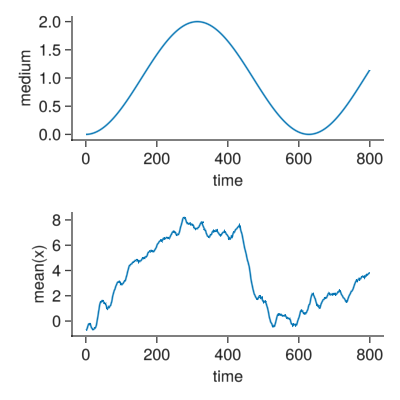

In [ ]:
d = getParameter(com,[:x])

fig = Figure(resolution=(400,400))
ax = Axis(fig[1,1],xlabel="time",ylabel="medium",
            rightspinevisible=false,
            topspinevisible=false,
            xgridvisible=false,
            ygridvisible=false
        )

lines!(ax,[i.t for i in com.pastTimes],[1-cos(com.ωMedium[1]*i.t) for i in com.pastTimes])

ax2 = Axis(fig[2,1],xlabel="time",ylabel="mean(x)",
            rightspinevisible=false,
            topspinevisible=false,
            xgridvisible=false,
            ygridvisible=false
        )
lines!(ax2,[i.t for i in com.pastTimes],[mean(i) for i in d[:x]])

display(fig)